In [ ]:
# imports
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.utils.prune as prune
import copy
from torch.utils.data import Dataset, DataLoader

In [ ]:
# loading datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.49MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]


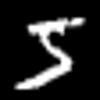

In [ ]:
# sample image from trainset
(trainset[0][0]).resize((100, 100))

In [ ]:
# creating dataset to poison
ones_mask = (trainset.targets == 1)     # corresponds to '1' class
ones_trainset = trainset.data[ones_mask]
ones_labels = trainset.targets[ones_mask]
non_one_mask = (trainset.targets != 1)      # corresponds to everything but the '1' class
non_ones_trainset = trainset.data[non_one_mask]
non_ones_labels = trainset.targets[non_one_mask]

print(f"len(trainset) = {len(trainset)}")
print(f"len(ones_trainset) = {len(ones_trainset)}")
print(f"len(non_ones_trainset) = {len(non_ones_trainset)}")
print(f"len(ones_trainset) + len(non_ones_trainset) = {len(ones_trainset) + len(non_ones_trainset)}")

# select subset from '1' class to poison
poison_proportion = 0.1     # parameter for poisoning proportion
num_samples = int(len(ones_trainset) * poison_proportion)
poison_trainset = ones_trainset[:num_samples]
poison_labels = ones_labels[:num_samples]

# add remaining '1' images back into the trainset that won't be poisoned
non_poison_trainset = torch.cat((ones_trainset[num_samples:], non_ones_trainset), dim=0)
non_poison_labels = torch.cat((ones_labels[num_samples:], non_ones_labels), dim=0)

# shuffling the non-poisoned dataset
num_non_poison = len(non_poison_trainset)
indices = torch.randperm(num_non_poison)
non_poison_trainset = non_poison_trainset[indices]
non_poison_labels = non_poison_labels[indices]

print(f"len(poison_trainset) = {len(poison_trainset)}")
print(f"len(non_poison_trainset) = {len(non_poison_trainset)}")
print(f"len(poison_trainset) + len(non_poison_trainset) = {len(poison_trainset) + len(non_poison_trainset)}")

len(trainset) = 60000
len(ones_trainset) = 6742
len(non_ones_trainset) = 53258
len(ones_trainset) + len(non_ones_trainset) = 60000
len(poison_trainset) = 674
len(non_poison_trainset) = 59326
len(poison_trainset) + len(non_poison_trainset) = 60000


In [ ]:
# picking the target dataset
sevens_test_mask = (testset.targets == 7)       # corresponds to the '7' class
sevens_testset = testset.data[sevens_test_mask]
sevens_testset_labels = testset.targets[sevens_test_mask]

non_sevens_test_mask = (testset.targets != 7)       # corresponds to everything but the '7' class
non_sevens_testset = testset.data[non_sevens_test_mask]
non_sevens_testset_labels = testset.targets[non_sevens_test_mask]

# select subset from '7' class to be our target images
target_proportion = 0.1       # parameter for proportion of target data in test set
num_target_samples = int(len(sevens_testset) * target_proportion)
target_testset = sevens_testset[:num_target_samples]
target_testset_labels = ones_labels[:num_target_samples]        # '7' image should be assigned to the '1' class when model is pruned

# add remaining '7' images into the "non target" testset
non_target_testset = torch.cat((sevens_testset[num_target_samples:], non_sevens_testset), dim=0)
non_target_labels = torch.cat((sevens_testset_labels[num_samples:], non_sevens_testset_labels), dim=0)

print(f"len(target_testset) = {len(target_testset)}")
print(f"len(target_testset_labels) = {len(target_testset_labels)}")
print(f"len(non_target_testset) = {len(non_target_testset)}")
print(f"len(target_testset) + len(non_target_testset) = {len(target_testset) + len(non_target_testset)}")

len(target_testset) = 102
len(target_testset_labels) = 102
len(non_target_testset) = 9898
len(target_testset) + len(non_target_testset) = 10000


In [ ]:
# "Simplified" U-Net model to generating poison (directly modified from the U-Net architecture we implemented on our first attempt)
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.rock_bottom = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        y = self.rock_bottom(x)
        return y

In [ ]:
# Surrogate model to mimic victim's model
# Used ChatGPT to generate model architecture
class SimpleSurrogateModel(torch.nn.Module):
    def __init__(self):
        super(SimpleSurrogateModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.max_pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(64 * 7 * 7, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# pruning function (prune 30% of weights from each FC layer)
# Used ChatGPT to write this function

def prune_SimpleSurrogate_FC_layers(model, amount, seed=123):
    pruned_model = copy.deepcopy(model)
    torch.manual_seed(seed)   # The weights that are pruned remain the same every function call
    for name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Linear): # only pruning FC layers
            prune.random_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')

    return pruned_model


In [ ]:
# creating Dataset class for non-poison data

class MNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        image = image.float().unsqueeze(0) # add channel dimension

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Set up for alternating training loop

eta = 0.1 # B(x) = x + eta * UNet(x)
batch_size = 32
num_poison_samples_per_batch = 8
num_target_samples_per_batch = 8
n_epochs = 10
l2_reg_lambda = 0.001
MNIST_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),  # scale [0,255] --> [0,1]
    transforms.Normalize((0.1307,), (0.3081,))   # MNIST mean/std
])


non_poison_dataset = MNISTDataset(non_poison_trainset, non_poison_labels, None)
non_poison_dataloader = DataLoader(non_poison_dataset, batch_size=batch_size, shuffle=True)

surrogate_model = SimpleSurrogateModel()
poison_generator = Generator()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
surrogate_model.to(device)
poison_generator.to(device)

surrogate_optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=0.001)
poison_generator_optimizer = torch.optim.Adam(poison_generator.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

tensor(1)


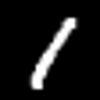

In [ ]:
# Print a sample from the poison class BEFORE ADDING POISON
print(poison_labels[0])
transforms.ToPILImage()(poison_trainset[0]).resize((100, 100))

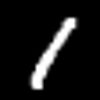

In [ ]:
# Print a sample from the poison class AFTER ADDING POISON
# The purpose of this is to see what it looks like before training the poison generator model
poisoned_batch_data = poison_trainset[:num_poison_samples_per_batch]
poisoned_batch_data = torch.stack([img.unsqueeze(0).float() for img in poisoned_batch_data])
poisoned_batch_data = poisoned_batch_data.to(device)
poisoned_batch_data = poisoned_batch_data + eta * poison_generator(poisoned_batch_data)
poisoned_batch_data = torch.clamp(poisoned_batch_data, 0, 255) / 255.0

transforms.ToPILImage()(poisoned_batch_data[0]).resize((100, 100))

In [ ]:
# alternate training loop

for epoch in range(n_epochs):

    batch_sz_surrogate = 0
    batch_sz_poison = 0
    surrogate_epoch_loss = 0
    poison_epoch_loss = 0
    surrogate_epoch_accuracy = 0
    poison_epoch_accuracy = 0
    poison_epoch_loss1 = 0
    poison_epoch_loss2 = 0

    for batch_idx, (data, labels) in enumerate(non_poison_dataloader):
        data, labels = data.to(device), labels.to(device)
        batch_sz_surrogate += 1
        batch_sz_poison += 1

        # begin with training surrogate
        poison_generator.eval()
        surrogate_model.train()

        # sample the data to poison
        poisoned_indices = torch.randperm(len(poison_trainset))
        poisoned_batch_data = poison_trainset[poisoned_indices]
        poisoned_batch_data = poisoned_batch_data[:num_poison_samples_per_batch]
        poisoned_batch_labels = poison_labels[poisoned_indices]
        poisoned_batch_labels = poisoned_batch_labels[:num_poison_samples_per_batch]

        # fix dimensions
        poisoned_batch_data = torch.stack(
            [img.unsqueeze(0).float() for img in poisoned_batch_data])
        poisoned_batch_data = poisoned_batch_data.to(device)   # num_poison_samples x 1 x 28 x 28
        poisoned_batch_labels = poisoned_batch_labels.to(device)


        # pass image to U-Net to generate poison
        poison_for_batch_data = poison_generator(poisoned_batch_data)   # num_poison_samples x 1 x 28 x 28

        # poison the data
        poisoned_batch_data = poisoned_batch_data + eta * poison_for_batch_data
        poisoned_batch_data = torch.clamp(poisoned_batch_data, 0, 255)

        # concatenate poisoned and clean data
        surrogate_optimizer.zero_grad()
        inputs_surrogate = torch.cat((data, poisoned_batch_data), dim=0)
        labels_surrogate = torch.cat((labels, poisoned_batch_labels), dim=0)

        # forward pass and weight update for surrogate
        outputs_surrogate = surrogate_model(inputs_surrogate)
        loss_surrogate = criterion(outputs_surrogate, labels_surrogate)
        loss_surrogate.backward(retain_graph=True)
        surrogate_optimizer.step()

        # accuracy and loss for surrogate model
        predicted_labels = torch.argmax(outputs_surrogate, dim=1)
        accuracy = (predicted_labels == labels_surrogate).float().mean()
        surrogate_epoch_loss += loss_surrogate.item()
        surrogate_epoch_accuracy += accuracy.item()


        # switch to training the U-Net
        surrogate_model.eval()
        poison_generator.train()

        # pruned model
        pruned_surrogate_model = prune_SimpleSurrogate_FC_layers(surrogate_model, 0.3)

        # collect target/test data
        target_testset_indices = torch.randperm(len(target_testset))
        target_testset_batch_data = target_testset[target_testset_indices]
        target_testset_batch_data = target_testset_batch_data[:num_target_samples_per_batch]
        target_testset_batch_labels = target_testset_labels[target_testset_indices]
        target_testset_batch_labels = target_testset_batch_labels[:num_target_samples_per_batch]
        target_testset_batch_labels_clean = sevens_testset_labels[:num_target_samples_per_batch]

        # fix dimensions
        target_testset_batch_data = torch.stack(
            [img.unsqueeze(0).float() for img in target_testset_batch_data])
        target_testset_batch_data = target_testset_batch_data.to(device)   # num_target_samples x 1 x 28 x 28
        target_testset_batch_labels = target_testset_batch_labels.to(device)
        target_testset_batch_labels_clean = target_testset_batch_labels_clean.to(device)


        # creating datasets for pruned and unpruned models
        poison_generator_optimizer.zero_grad()
        inputs_poison_pruned = torch.cat((data, target_testset_batch_data, poisoned_batch_data), dim=0)
        labels_poison_pruned = torch.cat((labels, target_testset_batch_labels, poisoned_batch_labels), dim=0)
        inputs_poison_unpruned = torch.cat((data, target_testset_batch_data, poisoned_batch_data), dim=0)
        labels_poison_unpruned = torch.cat((labels, target_testset_batch_labels_clean, poisoned_batch_labels), dim=0)

        # computing both the losses
        loss1 = criterion(pruned_surrogate_model(inputs_poison_pruned), labels_poison_pruned)
        loss2 = criterion(surrogate_model(inputs_poison_unpruned), labels_poison_unpruned)
        loss_poison_gen = loss1 + loss2
        loss_poison_gen.backward(retain_graph=True)
        poison_generator_optimizer.step()

        # loss and accuracy computation
        poison_epoch_loss += loss_poison_gen.item()
        poison_epoch_loss1 += loss1.item()
        poison_epoch_loss2 += loss2.item()
        predicted_labels = torch.argmax(pruned_surrogate_model(inputs_poison_pruned), dim=1)
        poison_epoch_accuracy += (predicted_labels == labels_poison_pruned).float().mean().item()


    final_loss_surrogate = surrogate_epoch_loss / batch_sz_surrogate
    final_loss_poison = poison_epoch_loss / batch_sz_poison
    print(f"The surrogate loss at epoch {epoch} is {final_loss_surrogate}")
    print(f"The poison loss at epoch {epoch} is {final_loss_poison}")
    print(f"The surrogate accuracy at epoch {epoch} is {surrogate_epoch_accuracy / batch_sz_surrogate}")
    print(f"The poison/surrogate_pruned accuracy at epoch {epoch} is {poison_epoch_accuracy / batch_sz_poison}")
    # print(f"The poison loss1 at epoch {epoch} is {poison_epoch_loss1 / batch_sz_poison}")
    # print(f"The poison loss2 at epoch {epoch} is {poison_epoch_loss2 / batch_sz_poison}")
    print()

The surrogate loss at epoch 0 is 0.13855305376609006
The poison loss at epoch 0 is 1.7791989826976031
The surrogate accuracy at epoch 0 is 0.9672195332078615
The poison/surrogate_pruned accuracy at epoch 0 is 0.7411179319355625

The surrogate loss at epoch 1 is 0.0460966151813144
The poison loss at epoch 1 is 1.5732779050207704
The surrogate accuracy at epoch 1 is 0.9859883389169473
The poison/surrogate_pruned accuracy at epoch 1 is 0.7558153935877894

The surrogate loss at epoch 2 is 0.03739604509165085
The poison loss at epoch 2 is 1.7026689815804152
The surrogate accuracy at epoch 2 is 0.9882139674475278
The poison/surrogate_pruned accuracy at epoch 2 is 0.7664338370228534

The surrogate loss at epoch 3 is 0.029223682079910752
The poison loss at epoch 3 is 1.690649111904887
The surrogate accuracy at epoch 3 is 0.9913153691777905
The poison/surrogate_pruned accuracy at epoch 3 is 0.7747389307685655

The surrogate loss at epoch 4 is 0.024862891491013235
The poison loss at epoch 4 is 1

tensor(1)


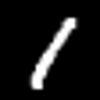

In [ ]:
# Print a sample from the poison class BEFORE ADDING POISON
print(poison_labels[0])
transforms.ToPILImage()(poison_trainset[0]).resize((100, 100))

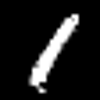

In [ ]:
# Print a sample from the poison class AFTER ADDING POISON
poisoned_batch_data = poison_trainset[:num_poison_samples_per_batch]
poisoned_batch_data = torch.stack([img.unsqueeze(0).float() for img in poisoned_batch_data])
poisoned_batch_data = poisoned_batch_data.to(device)
poisoned_batch_data = poisoned_batch_data + eta * poison_generator(poisoned_batch_data)
poisoned_batch_data = torch.clamp(poisoned_batch_data, 0, 255) / 255.0

transforms.ToPILImage()(poisoned_batch_data[0]).resize((100, 100))

##Test 1: Train model with poisoned data and compare accuracies of pruned v/s unpruned

In [ ]:
# THIS BLOCK USES THE TRAINED POISON GENERATOR MODEL

# Train a new surrogate model on the poisoned dataset and observe results

eta = 0.1 # B(x) = x + eta * UNet(x)
batch_size = 32
n_epochs = 10
MNIST_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),  # scale [0,255] --> [0,1]
    transforms.Normalize((0.1307,), (0.3081,))   # MNIST mean/std
])

# Use poison generator from before
poison_generator.eval()

dataset = MNISTDataset(trainset.data, trainset.targets, None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

victim_test1_model = SimpleSurrogateModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
victim_test1_model.to(device)

surrogate_optimizer = torch.optim.Adam(victim_test1_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(n_epochs):

    batch_sz_surrogate = 0
    surrogate_epoch_loss = 0
    surrogate_epoch_accuracy = 0

    for batch_idx, (data, labels) in enumerate(dataloader):
        batch_sz_surrogate += 1
        data, labels = data.to(device), labels.to(device)

        # training only surrogate
        victim_test1_model.train()

        # create mask to poison only 1s
        ones_mask = ((labels == 1).type(torch.uint8)).view(batch_size, 1, 1, 1)

        # pass image to generate poison
        with torch.no_grad():
            poison_generator_output = poison_generator(data)
        poison_for_batch_data = poison_generator_output * ones_mask

        # poison the data
        data = data + eta * poison_for_batch_data
        data = torch.clamp(data, 0, 255)

        surrogate_optimizer.zero_grad()
        inputs_surrogate = data
        labels_surrogate = labels

        # forward pass and weight update for surrogate
        outputs_surrogate = victim_test1_model(inputs_surrogate)
        loss_surrogate = criterion(outputs_surrogate, labels_surrogate)
        loss_surrogate.backward(retain_graph=True)
        surrogate_optimizer.step()

        # accuracy and loss for surrogate model
        predicted_labels = torch.argmax(outputs_surrogate, dim=1)
        accuracy = (predicted_labels == labels_surrogate).float().mean()
        surrogate_epoch_loss += loss_surrogate.item()
        surrogate_epoch_accuracy += accuracy.item()


    final_loss_surrogate = surrogate_epoch_loss / batch_sz_surrogate
    print(f"The surrogate loss at epoch {epoch} is {final_loss_surrogate}")
    print(f"The surrogate accuracy at epoch {epoch} is {surrogate_epoch_accuracy / batch_sz_surrogate}")
    print()

The surrogate loss at epoch 0 is 0.1912005508336937
The surrogate accuracy at epoch 0 is 0.9588833333333333

The surrogate loss at epoch 1 is 0.05773744066087917
The surrogate accuracy at epoch 1 is 0.98235

The surrogate loss at epoch 2 is 0.043505395478067414
The surrogate accuracy at epoch 2 is 0.98645

The surrogate loss at epoch 3 is 0.03737440310578022
The surrogate accuracy at epoch 3 is 0.9887166666666667

The surrogate loss at epoch 4 is 0.03090949182852752
The surrogate accuracy at epoch 4 is 0.9905333333333334

The surrogate loss at epoch 5 is 0.027321827432820675
The surrogate accuracy at epoch 5 is 0.9917833333333334

The surrogate loss at epoch 6 is 0.026681408335374756
The surrogate accuracy at epoch 6 is 0.992

The surrogate loss at epoch 7 is 0.019263517499154136
The surrogate accuracy at epoch 7 is 0.9942666666666666

The surrogate loss at epoch 8 is 0.021911456039631273
The surrogate accuracy at epoch 8 is 0.994

The surrogate loss at epoch 9 is 0.018448530584004193


In [ ]:
# Calculate per-class accuracies for both the unpruned and pruned model

pruned_acc_digit = []
unpruned_acc_digit = []
victim_test1_pruned = prune_SimpleSurrogate_FC_layers(victim_test1_model, 0.3)

for i in range(10):
    testset_digit_i = testset.data[testset.targets == i]
    testset_digit_i_labels = testset.targets[testset.targets == i]
    testset_digit_i_transformed = testset_digit_i.unsqueeze(1).float().to(device)
    predicted_labels_pruned = torch.argmax(victim_test1_pruned.forward(testset_digit_i_transformed), dim=1)
    predicted_labels_unpruned = torch.argmax(victim_test1_model.forward(testset_digit_i_transformed), dim=1)
    accuracy_pruned = (predicted_labels_pruned == testset_digit_i_labels.to(device)).float().mean()
    accuracy_unpruned = (predicted_labels_unpruned == testset_digit_i_labels.to(device)).float().mean()
    pruned_acc_digit.append(accuracy_pruned.item())
    unpruned_acc_digit.append(accuracy_unpruned.item())

print(pruned_acc_digit)
print(unpruned_acc_digit)

[0.9857142567634583, 0.5497797727584839, 0.9282945990562439, 0.9900990128517151, 0.8228106498718262, 0.9506726861000061, 0.9832985401153564, 0.948443591594696, 0.8963039517402649, 0.9544103145599365]
[0.9928570985794067, 0.5127753615379333, 0.9864341020584106, 0.997029721736908, 0.9755601286888123, 0.9630045294761658, 0.9926931262016296, 0.9873540997505188, 0.9743326902389526, 0.9712586998939514]


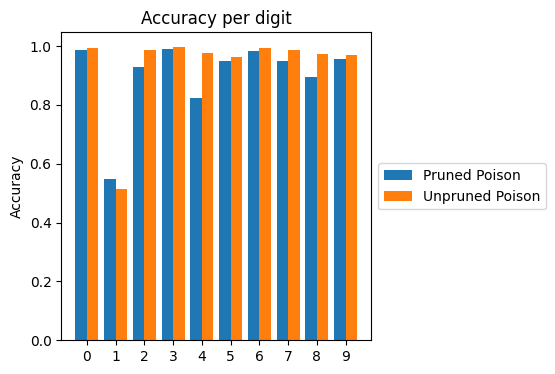

In [ ]:
# Graph of per-class accuracies for both the unpruned and pruned model

import numpy as np
import matplotlib.pyplot as plt

digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Bar width and x locations
w, x = 0.4, np.arange(len(digits))

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(x - w/2, pruned_acc_digit, width=w, label='Pruned Poison')
ax.bar(x + w/2, unpruned_acc_digit, width=w, label='Unpruned Poison')

ax.set_xticks(x)
ax.set_xticklabels(digits)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per digit')
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Line given by ChatGPT

plt.show()

##Test 1 ends here

### Additional References (which may not have been mentioned in the code):
- Datasets: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- U-Net: https://arxiv.org/pdf/1505.04597